# **Imports**

---
Below are all the **Modules** used in the **Notebook**.

In [8]:
from IPython.display import clear_output as cls
!pip install tf_explain
cls()

In [9]:
# Common
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf

# Data Loading
import tensorflow.data as tfd
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array

# Data Visualization
import matplotlib.pyplot as plt

# Models 
from keras.layers import ReLU
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Concatenate
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.models import Sequential, Model
from keras.layers import BatchNormalization

# Re Trained Model
from tensorflow.keras.applications import ResNet50

# Model Visualization
from tensorflow.keras.utils import plot_model

# Callbacks 
from keras.callbacks import Callback, ModelCheckpoint

# Model Explaination
from tf_explain.core.grad_cam import GradCAM

In [10]:
import os

# Specify the directory path
image_dir = '/kaggle/input/dataset3/data/images/'

# List all files in the directory
files = os.listdir(image_dir)

# Show files
print(f"Files in the directory: {files}")


Files in the directory: ['274.tif', '123.tif', '130.tif', '170.tif', '66.tif', '296.tif', '215.tif', '116.tif', '204.tif', '171.tif', '18.tif', '232.tif', '168.tif', '125.tif', '216.tif', '233.tif', '94.tif', '86.tif', '256.tif', '46.tif', '136.tif', '208.tif', '245.tif', '45.tif', '148.tif', '254.tif', '276.tif', '79.tif', '197.tif', '164.tif', '17.tif', '5.tif', '90.tif', '161.tif', '2.tif', '278.tif', '96.tif', '29.tif', '68.tif', '100.tif', '250.tif', '252.tif', '300.tif', '104.tif', '103.tif', '19.tif', '38.tif', '15.tif', '202.tif', '114.tif', '271.tif', '50.tif', '247.tif', '139.tif', '230.tif', '221.tif', '126.tif', '25.tif', '194.tif', '78.tif', '81.tif', '212.tif', '92.tif', '147.tif', '31.tif', '191.tif', '106.tif', '244.tif', '80.tif', '61.tif', '49.tif', '257.tif', '255.tif', '117.tif', '289.tif', '193.tif', '13.tif', '174.tif', '220.tif', '281.tif', '112.tif', '143.tif', '239.tif', '214.tif', '24.tif', '23.tif', '285.tif', '155.tif', '198.tif', '40.tif', '302.tif', '108.t

# **Data Loading**

In [11]:
import glob

# Specify Root Path
root_path = '/kaggle/input/dataset3/data/images/'

# All Images (now looking for .tif files)
image_paths = glob.glob(root_path + "*.tif")

# Count the number of images
n_images = len(image_paths)

# Show
print(f"Total Number of Images : {n_images}")


Total Number of Images : 306


In [12]:
def load_image(path, IMAGE_SIZE):
    image = img_to_array(load_img(path))
    image = tfi.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image

def load_data(image_paths, trim=None, IMAGE_SIZE=256, BATCH_SIZE=8, files=False):
    
    # Collect Paths
    if trim is not None:
        image_paths = image_paths[:trim]
    
    mask_paths = []
    for path in image_paths:
        mask_path = path.replace(".png", "_mask.png")
        mask_paths.append(mask_path)
    
    # Create Space
    images, masks = np.zeros(shape=(len(image_paths), IMAGE_SIZE, IMAGE_SIZE, 3)), np.zeros(shape=(len(image_paths), IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # Load Images
    for i, (image_path, mask_path) in tqdm(enumerate(zip(image_paths, mask_paths)), desc="Loading"):
        image = load_image(image_path, IMAGE_SIZE=IMAGE_SIZE)
        mask  = load_image(mask_path, IMAGE_SIZE=IMAGE_SIZE)
        images[i] = image
        masks[i] = mask
    
    # Dataset
    data = tfd.Dataset.from_tensor_slices((images, masks))
    data = data.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True)
    data = data.prefetch(tfd.AUTOTUNE)
    
    if files:
        return data, images, masks
    return data

In [13]:
def load_image(path, IMAGE_SIZE):
    image = img_to_array(load_img(path))
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32)
    return image


In [14]:
import cv2
import numpy as np
import tensorflow as tf

def load_image(path, IMAGE_SIZE):
    print(f"Attempting to load image from {path}")
    
    try:
        # Load the image using OpenCV
        image = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # Load the image as is (including .tif support)
        
        if image is None:
            raise ValueError(f"Unable to load image from {path}")
        
        print(f"Successfully loaded image: {path}")
        
        # Resize the image
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        
        # Convert the image to float32
        image = image.astype(np.float32)
        
        # Normalize the image if needed (depending on your model's requirement)
        image = image / 255.0
        
        print(f"Image loaded and resized: {path}")
        return image
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None


In [15]:
# Test loading a single image with OpenCV
image_path = '/kaggle/input/dataset3/data/images/0.tif'  # Use any image path from your directory
load_image(image_path, 256)  # Assuming 256 is your image size


Attempting to load image from /kaggle/input/dataset3/data/images/0.tif
Error loading image /kaggle/input/dataset3/data/images/0.tif: Unable to load image from /kaggle/input/dataset3/data/images/0.tif


[ERROR:0@710.897] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/0.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12



In [16]:
train_ds = load_data(image_paths, trim=200)
valid_ds, val_images, val_masks = load_data(image_paths, trim=10, files=True)

Loading: 0it [00:00, ?it/s][ERROR:0@710.922] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/274.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@710.923] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/274.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@710.933] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/123.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_t

Attempting to load image from /kaggle/input/dataset3/data/images/274.tif
Error loading image /kaggle/input/dataset3/data/images/274.tif: Unable to load image from /kaggle/input/dataset3/data/images/274.tif
Attempting to load image from /kaggle/input/dataset3/data/images/274.tif
Error loading image /kaggle/input/dataset3/data/images/274.tif: Unable to load image from /kaggle/input/dataset3/data/images/274.tif
Attempting to load image from /kaggle/input/dataset3/data/images/123.tif
Error loading image /kaggle/input/dataset3/data/images/123.tif: Unable to load image from /kaggle/input/dataset3/data/images/123.tif
Attempting to load image from /kaggle/input/dataset3/data/images/123.tif
Error loading image /kaggle/input/dataset3/data/images/123.tif: Unable to load image from /kaggle/input/dataset3/data/images/123.tif
Attempting to load image from /kaggle/input/dataset3/data/images/130.tif
Error loading image /kaggle/input/dataset3/data/images/130.tif: Unable to load image from /kaggle/input

[ERROR:0@711.036] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/171.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.037] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/171.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.048] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/18.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unsp

Error loading image /kaggle/input/dataset3/data/images/216.tif: Unable to load image from /kaggle/input/dataset3/data/images/216.tif
Attempting to load image from /kaggle/input/dataset3/data/images/216.tif
Error loading image /kaggle/input/dataset3/data/images/216.tif: Unable to load image from /kaggle/input/dataset3/data/images/216.tif
Attempting to load image from /kaggle/input/dataset3/data/images/233.tif
Error loading image /kaggle/input/dataset3/data/images/233.tif: Unable to load image from /kaggle/input/dataset3/data/images/233.tif
Attempting to load image from /kaggle/input/dataset3/data/images/233.tif
Error loading image /kaggle/input/dataset3/data/images/233.tif: Unable to load image from /kaggle/input/dataset3/data/images/233.tif
Attempting to load image from /kaggle/input/dataset3/data/images/94.tif


[ERROR:0@711.121] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/94.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.122] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/94.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.133] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/86.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspec

Error loading image /kaggle/input/dataset3/data/images/94.tif: Unable to load image from /kaggle/input/dataset3/data/images/94.tif
Attempting to load image from /kaggle/input/dataset3/data/images/94.tif
Error loading image /kaggle/input/dataset3/data/images/94.tif: Unable to load image from /kaggle/input/dataset3/data/images/94.tif
Attempting to load image from /kaggle/input/dataset3/data/images/86.tif
Error loading image /kaggle/input/dataset3/data/images/86.tif: Unable to load image from /kaggle/input/dataset3/data/images/86.tif
Attempting to load image from /kaggle/input/dataset3/data/images/86.tif
Error loading image /kaggle/input/dataset3/data/images/86.tif: Unable to load image from /kaggle/input/dataset3/data/images/86.tif
Attempting to load image from /kaggle/input/dataset3/data/images/256.tif
Error loading image /kaggle/input/dataset3/data/images/256.tif: Unable to load image from /kaggle/input/dataset3/data/images/256.tif
Attempting to load image from /kaggle/input/dataset3/d

[ERROR:0@711.149] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/256.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.150] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/256.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.163] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/46.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unsp

Attempting to load image from /kaggle/input/dataset3/data/images/276.tif
Error loading image /kaggle/input/dataset3/data/images/276.tif: Unable to load image from /kaggle/input/dataset3/data/images/276.tif
Attempting to load image from /kaggle/input/dataset3/data/images/276.tif


[ERROR:0@711.249] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/276.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.250] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/276.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

Loading: 27it [00:00, 79.19it/s]

Error loading image /kaggle/input/dataset3/data/images/276.tif: Unable to load image from /kaggle/input/dataset3/data/images/276.tif
Attempting to load image from /kaggle/input/dataset3/data/images/79.tif
Error loading image /kaggle/input/dataset3/data/images/79.tif: Unable to load image from /kaggle/input/dataset3/data/images/79.tif
Attempting to load image from /kaggle/input/dataset3/data/images/79.tif
Error loading image /kaggle/input/dataset3/data/images/79.tif: Unable to load image from /kaggle/input/dataset3/data/images/79.tif
Attempting to load image from /kaggle/input/dataset3/data/images/197.tif
Error loading image /kaggle/input/dataset3/data/images/197.tif: Unable to load image from /kaggle/input/dataset3/data/images/197.tif
Attempting to load image from /kaggle/input/dataset3/data/images/197.tif
Error loading image /kaggle/input/dataset3/data/images/197.tif: Unable to load image from /kaggle/input/dataset3/data/images/197.tif
Attempting to load image from /kaggle/input/datas

[ERROR:0@711.261] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/79.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.262] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/79.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.273] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/197.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspe

Attempting to load image from /kaggle/input/dataset3/data/images/5.tif
Error loading image /kaggle/input/dataset3/data/images/5.tif: Unable to load image from /kaggle/input/dataset3/data/images/5.tif
Attempting to load image from /kaggle/input/dataset3/data/images/5.tif
Error loading image /kaggle/input/dataset3/data/images/5.tif: Unable to load image from /kaggle/input/dataset3/data/images/5.tif
Attempting to load image from /kaggle/input/dataset3/data/images/90.tif


[ERROR:0@711.325] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/90.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.326] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/90.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.337] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/161.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspe

Error loading image /kaggle/input/dataset3/data/images/90.tif: Unable to load image from /kaggle/input/dataset3/data/images/90.tif
Attempting to load image from /kaggle/input/dataset3/data/images/90.tif
Error loading image /kaggle/input/dataset3/data/images/90.tif: Unable to load image from /kaggle/input/dataset3/data/images/90.tif
Attempting to load image from /kaggle/input/dataset3/data/images/161.tif
Error loading image /kaggle/input/dataset3/data/images/161.tif: Unable to load image from /kaggle/input/dataset3/data/images/161.tif
Attempting to load image from /kaggle/input/dataset3/data/images/161.tif
Error loading image /kaggle/input/dataset3/data/images/161.tif: Unable to load image from /kaggle/input/dataset3/data/images/161.tif
Attempting to load image from /kaggle/input/dataset3/data/images/2.tif
Error loading image /kaggle/input/dataset3/data/images/2.tif: Unable to load image from /kaggle/input/dataset3/data/images/2.tif
Attempting to load image from /kaggle/input/dataset3/d

[ERROR:0@711.363] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/278.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.365] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/278.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.375] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/96.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unsp

Error loading image /kaggle/input/dataset3/data/images/252.tif: Unable to load image from /kaggle/input/dataset3/data/images/252.tif
Attempting to load image from /kaggle/input/dataset3/data/images/252.tif
Error loading image /kaggle/input/dataset3/data/images/252.tif: Unable to load image from /kaggle/input/dataset3/data/images/252.tif
Attempting to load image from /kaggle/input/dataset3/data/images/300.tif


[ERROR:0@711.456] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/300.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.457] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/300.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

Loading: 43it [00:00, 77.98it/s]

Error loading image /kaggle/input/dataset3/data/images/300.tif: Unable to load image from /kaggle/input/dataset3/data/images/300.tif
Attempting to load image from /kaggle/input/dataset3/data/images/300.tif
Error loading image /kaggle/input/dataset3/data/images/300.tif: Unable to load image from /kaggle/input/dataset3/data/images/300.tif
Attempting to load image from /kaggle/input/dataset3/data/images/104.tif
Error loading image /kaggle/input/dataset3/data/images/104.tif: Unable to load image from /kaggle/input/dataset3/data/images/104.tif
Attempting to load image from /kaggle/input/dataset3/data/images/104.tif
Error loading image /kaggle/input/dataset3/data/images/104.tif: Unable to load image from /kaggle/input/dataset3/data/images/104.tif
Attempting to load image from /kaggle/input/dataset3/data/images/103.tif
Error loading image /kaggle/input/dataset3/data/images/103.tif: Unable to load image from /kaggle/input/dataset3/data/images/103.tif
Attempting to load image from /kaggle/input

[ERROR:0@711.468] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/104.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.469] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/104.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.479] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/103.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Error loading image /kaggle/input/dataset3/data/images/38.tif: Unable to load image from /kaggle/input/dataset3/data/images/38.tif
Attempting to load image from /kaggle/input/dataset3/data/images/38.tif
Error loading image /kaggle/input/dataset3/data/images/38.tif: Unable to load image from /kaggle/input/dataset3/data/images/38.tif
Attempting to load image from /kaggle/input/dataset3/data/images/15.tif
Error loading image /kaggle/input/dataset3/data/images/15.tif: Unable to load image from /kaggle/input/dataset3/data/images/15.tif
Attempting to load image from /kaggle/input/dataset3/data/images/15.tif
Error loading image /kaggle/input/dataset3/data/images/15.tif: Unable to load image from /kaggle/input/dataset3/data/images/15.tif
Attempting to load image from /kaggle/input/dataset3/data/images/202.tif


[ERROR:0@711.530] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/202.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.532] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/202.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.544] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/114.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Error loading image /kaggle/input/dataset3/data/images/202.tif: Unable to load image from /kaggle/input/dataset3/data/images/202.tif
Attempting to load image from /kaggle/input/dataset3/data/images/202.tif
Error loading image /kaggle/input/dataset3/data/images/202.tif: Unable to load image from /kaggle/input/dataset3/data/images/202.tif
Attempting to load image from /kaggle/input/dataset3/data/images/114.tif
Error loading image /kaggle/input/dataset3/data/images/114.tif: Unable to load image from /kaggle/input/dataset3/data/images/114.tif
Attempting to load image from /kaggle/input/dataset3/data/images/114.tif
Error loading image /kaggle/input/dataset3/data/images/114.tif: Unable to load image from /kaggle/input/dataset3/data/images/114.tif
Attempting to load image from /kaggle/input/dataset3/data/images/271.tif
Error loading image /kaggle/input/dataset3/data/images/271.tif: Unable to load image from /kaggle/input/dataset3/data/images/271.tif
Attempting to load image from /kaggle/input

[ERROR:0@711.573] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/50.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.574] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/50.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.586] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/247.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspe

Error loading image /kaggle/input/dataset3/data/images/126.tif: Unable to load image from /kaggle/input/dataset3/data/images/126.tif
Attempting to load image from /kaggle/input/dataset3/data/images/126.tif
Error loading image /kaggle/input/dataset3/data/images/126.tif: Unable to load image from /kaggle/input/dataset3/data/images/126.tif
Attempting to load image from /kaggle/input/dataset3/data/images/25.tif


[ERROR:0@711.662] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/25.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.663] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/25.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.673] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/194.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspe

Error loading image /kaggle/input/dataset3/data/images/25.tif: Unable to load image from /kaggle/input/dataset3/data/images/25.tif
Attempting to load image from /kaggle/input/dataset3/data/images/25.tif
Error loading image /kaggle/input/dataset3/data/images/25.tif: Unable to load image from /kaggle/input/dataset3/data/images/25.tif
Attempting to load image from /kaggle/input/dataset3/data/images/194.tif
Error loading image /kaggle/input/dataset3/data/images/194.tif: Unable to load image from /kaggle/input/dataset3/data/images/194.tif
Attempting to load image from /kaggle/input/dataset3/data/images/194.tif
Error loading image /kaggle/input/dataset3/data/images/194.tif: Unable to load image from /kaggle/input/dataset3/data/images/194.tif
Attempting to load image from /kaggle/input/dataset3/data/images/78.tif
Error loading image /kaggle/input/dataset3/data/images/78.tif: Unable to load image from /kaggle/input/dataset3/data/images/78.tif
Attempting to load image from /kaggle/input/dataset

[ERROR:0@711.687] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/78.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.688] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/78.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.698] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/81.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspec

Error loading image /kaggle/input/dataset3/data/images/212.tif: Unable to load image from /kaggle/input/dataset3/data/images/212.tif
Attempting to load image from /kaggle/input/dataset3/data/images/212.tif
Error loading image /kaggle/input/dataset3/data/images/212.tif: Unable to load image from /kaggle/input/dataset3/data/images/212.tif
Attempting to load image from /kaggle/input/dataset3/data/images/92.tif
Error loading image /kaggle/input/dataset3/data/images/92.tif: Unable to load image from /kaggle/input/dataset3/data/images/92.tif
Attempting to load image from /kaggle/input/dataset3/data/images/92.tif
Error loading image /kaggle/input/dataset3/data/images/92.tif: Unable to load image from /kaggle/input/dataset3/data/images/92.tif
Attempting to load image from /kaggle/input/dataset3/data/images/147.tif


[ERROR:0@711.735] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/147.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.737] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/147.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.747] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/31.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unsp

Error loading image /kaggle/input/dataset3/data/images/147.tif: Unable to load image from /kaggle/input/dataset3/data/images/147.tif
Attempting to load image from /kaggle/input/dataset3/data/images/147.tif
Error loading image /kaggle/input/dataset3/data/images/147.tif: Unable to load image from /kaggle/input/dataset3/data/images/147.tif
Attempting to load image from /kaggle/input/dataset3/data/images/31.tif
Error loading image /kaggle/input/dataset3/data/images/31.tif: Unable to load image from /kaggle/input/dataset3/data/images/31.tif
Attempting to load image from /kaggle/input/dataset3/data/images/31.tif
Error loading image /kaggle/input/dataset3/data/images/31.tif: Unable to load image from /kaggle/input/dataset3/data/images/31.tif
Attempting to load image from /kaggle/input/dataset3/data/images/191.tif
Error loading image /kaggle/input/dataset3/data/images/191.tif: Unable to load image from /kaggle/input/dataset3/data/images/191.tif
Attempting to load image from /kaggle/input/datas

[ERROR:0@711.800] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/80.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.801] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/80.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.813] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/61.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspec

Error loading image /kaggle/input/dataset3/data/images/255.tif: Unable to load image from /kaggle/input/dataset3/data/images/255.tif
Attempting to load image from /kaggle/input/dataset3/data/images/255.tif
Error loading image /kaggle/input/dataset3/data/images/255.tif: Unable to load image from /kaggle/input/dataset3/data/images/255.tif
Attempting to load image from /kaggle/input/dataset3/data/images/117.tif


[ERROR:0@711.864] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/117.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.865] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/117.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.877] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/289.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Error loading image /kaggle/input/dataset3/data/images/117.tif: Unable to load image from /kaggle/input/dataset3/data/images/117.tif
Attempting to load image from /kaggle/input/dataset3/data/images/117.tif
Error loading image /kaggle/input/dataset3/data/images/117.tif: Unable to load image from /kaggle/input/dataset3/data/images/117.tif
Attempting to load image from /kaggle/input/dataset3/data/images/289.tif
Error loading image /kaggle/input/dataset3/data/images/289.tif: Unable to load image from /kaggle/input/dataset3/data/images/289.tif
Attempting to load image from /kaggle/input/dataset3/data/images/289.tif
Error loading image /kaggle/input/dataset3/data/images/289.tif: Unable to load image from /kaggle/input/dataset3/data/images/289.tif
Attempting to load image from /kaggle/input/dataset3/data/images/193.tif
Error loading image /kaggle/input/dataset3/data/images/193.tif: Unable to load image from /kaggle/input/dataset3/data/images/193.tif
Attempting to load image from /kaggle/input

[ERROR:0@711.901] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/13.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.901] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/13.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.912] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/174.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspe

Error loading image /kaggle/input/dataset3/data/images/174.tif: Unable to load image from /kaggle/input/dataset3/data/images/174.tif
Attempting to load image from /kaggle/input/dataset3/data/images/220.tif
Error loading image /kaggle/input/dataset3/data/images/220.tif: Unable to load image from /kaggle/input/dataset3/data/images/220.tif
Attempting to load image from /kaggle/input/dataset3/data/images/220.tif
Error loading image /kaggle/input/dataset3/data/images/220.tif: Unable to load image from /kaggle/input/dataset3/data/images/220.tif
Attempting to load image from /kaggle/input/dataset3/data/images/281.tif


[ERROR:0@711.937] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/281.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.938] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/281.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@711.950] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/112.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Error loading image /kaggle/input/dataset3/data/images/281.tif: Unable to load image from /kaggle/input/dataset3/data/images/281.tif
Attempting to load image from /kaggle/input/dataset3/data/images/281.tif
Error loading image /kaggle/input/dataset3/data/images/281.tif: Unable to load image from /kaggle/input/dataset3/data/images/281.tif
Attempting to load image from /kaggle/input/dataset3/data/images/112.tif
Error loading image /kaggle/input/dataset3/data/images/112.tif: Unable to load image from /kaggle/input/dataset3/data/images/112.tif
Attempting to load image from /kaggle/input/dataset3/data/images/112.tif
Error loading image /kaggle/input/dataset3/data/images/112.tif: Unable to load image from /kaggle/input/dataset3/data/images/112.tif
Attempting to load image from /kaggle/input/dataset3/data/images/143.tif
Error loading image /kaggle/input/dataset3/data/images/143.tif: Unable to load image from /kaggle/input/dataset3/data/images/143.tif
Attempting to load image from /kaggle/input

[ERROR:0@712.006] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/24.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.007] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/24.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.017] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/23.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspec

Error loading image /kaggle/input/dataset3/data/images/40.tif: Unable to load image from /kaggle/input/dataset3/data/images/40.tif
Attempting to load image from /kaggle/input/dataset3/data/images/40.tif
Error loading image /kaggle/input/dataset3/data/images/40.tif: Unable to load image from /kaggle/input/dataset3/data/images/40.tif
Attempting to load image from /kaggle/input/dataset3/data/images/302.tif
Error loading image /kaggle/input/dataset3/data/images/302.tif: Unable to load image from /kaggle/input/dataset3/data/images/302.tif
Attempting to load image from /kaggle/input/dataset3/data/images/302.tif
Error loading image /kaggle/input/dataset3/data/images/302.tif: Unable to load image from /kaggle/input/dataset3/data/images/302.tif
Attempting to load image from /kaggle/input/dataset3/data/images/108.tif


[ERROR:0@712.114] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/108.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.116] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/108.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

Loading: 92it [00:01, 73.04it/s][ERROR:0@712.129] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/288.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/gr

Error loading image /kaggle/input/dataset3/data/images/108.tif: Unable to load image from /kaggle/input/dataset3/data/images/108.tif
Attempting to load image from /kaggle/input/dataset3/data/images/108.tif
Error loading image /kaggle/input/dataset3/data/images/108.tif: Unable to load image from /kaggle/input/dataset3/data/images/108.tif
Attempting to load image from /kaggle/input/dataset3/data/images/288.tif
Error loading image /kaggle/input/dataset3/data/images/288.tif: Unable to load image from /kaggle/input/dataset3/data/images/288.tif
Attempting to load image from /kaggle/input/dataset3/data/images/288.tif
Error loading image /kaggle/input/dataset3/data/images/288.tif: Unable to load image from /kaggle/input/dataset3/data/images/288.tif
Attempting to load image from /kaggle/input/dataset3/data/images/236.tif


[ERROR:0@712.141] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/236.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.143] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/236.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.155] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/131.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Error loading image /kaggle/input/dataset3/data/images/236.tif: Unable to load image from /kaggle/input/dataset3/data/images/236.tif
Attempting to load image from /kaggle/input/dataset3/data/images/236.tif
Error loading image /kaggle/input/dataset3/data/images/236.tif: Unable to load image from /kaggle/input/dataset3/data/images/236.tif
Attempting to load image from /kaggle/input/dataset3/data/images/131.tif
Error loading image /kaggle/input/dataset3/data/images/131.tif: Unable to load image from /kaggle/input/dataset3/data/images/131.tif
Attempting to load image from /kaggle/input/dataset3/data/images/131.tif
Error loading image /kaggle/input/dataset3/data/images/131.tif: Unable to load image from /kaggle/input/dataset3/data/images/131.tif
Attempting to load image from /kaggle/input/dataset3/data/images/39.tif
Error loading image /kaggle/input/dataset3/data/images/39.tif: Unable to load image from /kaggle/input/dataset3/data/images/39.tif
Attempting to load image from /kaggle/input/da

[ERROR:0@712.228] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/258.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.229] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/258.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.240] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/76.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unsp

Error loading image /kaggle/input/dataset3/data/images/150.tif: Unable to load image from /kaggle/input/dataset3/data/images/150.tif
Attempting to load image from /kaggle/input/dataset3/data/images/150.tif
Error loading image /kaggle/input/dataset3/data/images/150.tif: Unable to load image from /kaggle/input/dataset3/data/images/150.tif
Attempting to load image from /kaggle/input/dataset3/data/images/298.tif


[ERROR:0@712.282] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/298.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.283] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/298.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12



Error loading image /kaggle/input/dataset3/data/images/298.tif: Unable to load image from /kaggle/input/dataset3/data/images/298.tif
Attempting to load image from /kaggle/input/dataset3/data/images/298.tif
Error loading image /kaggle/input/dataset3/data/images/298.tif: Unable to load image from /kaggle/input/dataset3/data/images/298.tif
Attempting to load image from /kaggle/input/dataset3/data/images/16.tif
Error loading image /kaggle/input/dataset3/data/images/16.tif: Unable to load image from /kaggle/input/dataset3/data/images/16.tif
Attempting to load image from /kaggle/input/dataset3/data/images/16.tif
Error loading image /kaggle/input/dataset3/data/images/16.tif: Unable to load image from /kaggle/input/dataset3/data/images/16.tif
Attempting to load image from /kaggle/input/dataset3/data/images/134.tif
Error loading image /kaggle/input/dataset3/data/images/134.tif: Unable to load image from /kaggle/input/dataset3/data/images/134.tif
Attempting to load image from /kaggle/input/datas

[ERROR:0@712.293] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/16.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.294] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/16.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.305] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/134.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspe

Error loading image /kaggle/input/dataset3/data/images/200.tif: Unable to load image from /kaggle/input/dataset3/data/images/200.tif
Attempting to load image from /kaggle/input/dataset3/data/images/267.tif
Error loading image /kaggle/input/dataset3/data/images/267.tif: Unable to load image from /kaggle/input/dataset3/data/images/267.tif
Attempting to load image from /kaggle/input/dataset3/data/images/267.tif
Error loading image /kaggle/input/dataset3/data/images/267.tif: Unable to load image from /kaggle/input/dataset3/data/images/267.tif
Attempting to load image from /kaggle/input/dataset3/data/images/3.tif


[ERROR:0@712.346] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/3.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.347] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/3.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.357] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/67.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecif

Error loading image /kaggle/input/dataset3/data/images/3.tif: Unable to load image from /kaggle/input/dataset3/data/images/3.tif
Attempting to load image from /kaggle/input/dataset3/data/images/3.tif
Error loading image /kaggle/input/dataset3/data/images/3.tif: Unable to load image from /kaggle/input/dataset3/data/images/3.tif
Attempting to load image from /kaggle/input/dataset3/data/images/67.tif
Error loading image /kaggle/input/dataset3/data/images/67.tif: Unable to load image from /kaggle/input/dataset3/data/images/67.tif
Attempting to load image from /kaggle/input/dataset3/data/images/67.tif
Error loading image /kaggle/input/dataset3/data/images/67.tif: Unable to load image from /kaggle/input/dataset3/data/images/67.tif
Attempting to load image from /kaggle/input/dataset3/data/images/4.tif
Error loading image /kaggle/input/dataset3/data/images/4.tif: Unable to load image from /kaggle/input/dataset3/data/images/4.tif
Attempting to load image from /kaggle/input/dataset3/data/images/

[ERROR:0@712.432] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/0.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.434] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/0.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.444] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/98.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecif

Error loading image /kaggle/input/dataset3/data/images/242.tif: Unable to load image from /kaggle/input/dataset3/data/images/242.tif
Attempting to load image from /kaggle/input/dataset3/data/images/242.tif
Error loading image /kaggle/input/dataset3/data/images/242.tif: Unable to load image from /kaggle/input/dataset3/data/images/242.tif
Attempting to load image from /kaggle/input/dataset3/data/images/87.tif
Error loading image /kaggle/input/dataset3/data/images/87.tif: Unable to load image from /kaggle/input/dataset3/data/images/87.tif
Attempting to load image from /kaggle/input/dataset3/data/images/87.tif
Error loading image /kaggle/input/dataset3/data/images/87.tif: Unable to load image from /kaggle/input/dataset3/data/images/87.tif
Attempting to load image from /kaggle/input/dataset3/data/images/260.tif
Error loading image /kaggle/input/dataset3/data/images/260.tif: Unable to load image from /kaggle/input/dataset3/data/images/260.tif
Attempting to load image from /kaggle/input/datas

[ERROR:0@712.520] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/301.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.521] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/301.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.533] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/129.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Error loading image /kaggle/input/dataset3/data/images/301.tif: Unable to load image from /kaggle/input/dataset3/data/images/301.tif
Attempting to load image from /kaggle/input/dataset3/data/images/301.tif
Error loading image /kaggle/input/dataset3/data/images/301.tif: Unable to load image from /kaggle/input/dataset3/data/images/301.tif
Attempting to load image from /kaggle/input/dataset3/data/images/129.tif
Error loading image /kaggle/input/dataset3/data/images/129.tif: Unable to load image from /kaggle/input/dataset3/data/images/129.tif
Attempting to load image from /kaggle/input/dataset3/data/images/129.tif
Error loading image /kaggle/input/dataset3/data/images/129.tif: Unable to load image from /kaggle/input/dataset3/data/images/129.tif
Attempting to load image from /kaggle/input/dataset3/data/images/190.tif
Error loading image /kaggle/input/dataset3/data/images/190.tif: Unable to load image from /kaggle/input/dataset3/data/images/190.tif
Attempting to load image from /kaggle/input

[ERROR:0@712.556] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/177.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.557] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/177.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.568] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/185.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Attempting to load image from /kaggle/input/dataset3/data/images/177.tif
Error loading image /kaggle/input/dataset3/data/images/177.tif: Unable to load image from /kaggle/input/dataset3/data/images/177.tif
Attempting to load image from /kaggle/input/dataset3/data/images/177.tif
Error loading image /kaggle/input/dataset3/data/images/177.tif: Unable to load image from /kaggle/input/dataset3/data/images/177.tif
Attempting to load image from /kaggle/input/dataset3/data/images/185.tif
Error loading image /kaggle/input/dataset3/data/images/185.tif: Unable to load image from /kaggle/input/dataset3/data/images/185.tif
Attempting to load image from /kaggle/input/dataset3/data/images/185.tif
Error loading image /kaggle/input/dataset3/data/images/185.tif: Unable to load image from /kaggle/input/dataset3/data/images/185.tif
Attempting to load image from /kaggle/input/dataset3/data/images/101.tif
Error loading image /kaggle/input/dataset3/data/images/101.tif: Unable to load image from /kaggle/input

[ERROR:0@712.647] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/74.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.648] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/74.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.659] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/180.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspe

Error loading image /kaggle/input/dataset3/data/images/75.tif: Unable to load image from /kaggle/input/dataset3/data/images/75.tif
Attempting to load image from /kaggle/input/dataset3/data/images/75.tif
Error loading image /kaggle/input/dataset3/data/images/75.tif: Unable to load image from /kaggle/input/dataset3/data/images/75.tif
Attempting to load image from /kaggle/input/dataset3/data/images/237.tif
Error loading image /kaggle/input/dataset3/data/images/237.tif: Unable to load image from /kaggle/input/dataset3/data/images/237.tif
Attempting to load image from /kaggle/input/dataset3/data/images/237.tif
Error loading image /kaggle/input/dataset3/data/images/237.tif: Unable to load image from /kaggle/input/dataset3/data/images/237.tif
Attempting to load image from /kaggle/input/dataset3/data/images/187.tif
Error loading image /kaggle/input/dataset3/data/images/187.tif: Unable to load image from /kaggle/input/dataset3/data/images/187.tif
Attempting to load image from /kaggle/input/data

[ERROR:0@712.725] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/154.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.727] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/154.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.743] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/122.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Error loading image /kaggle/input/dataset3/data/images/154.tif: Unable to load image from /kaggle/input/dataset3/data/images/154.tif
Attempting to load image from /kaggle/input/dataset3/data/images/154.tif
Error loading image /kaggle/input/dataset3/data/images/154.tif: Unable to load image from /kaggle/input/dataset3/data/images/154.tif
Attempting to load image from /kaggle/input/dataset3/data/images/122.tif
Error loading image /kaggle/input/dataset3/data/images/122.tif: Unable to load image from /kaggle/input/dataset3/data/images/122.tif
Attempting to load image from /kaggle/input/dataset3/data/images/122.tif
Error loading image /kaggle/input/dataset3/data/images/122.tif: Unable to load image from /kaggle/input/dataset3/data/images/122.tif
Attempting to load image from /kaggle/input/dataset3/data/images/105.tif


[ERROR:0@712.757] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/105.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.758] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/105.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.769] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/261.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Error loading image /kaggle/input/dataset3/data/images/105.tif: Unable to load image from /kaggle/input/dataset3/data/images/105.tif
Attempting to load image from /kaggle/input/dataset3/data/images/105.tif
Error loading image /kaggle/input/dataset3/data/images/105.tif: Unable to load image from /kaggle/input/dataset3/data/images/105.tif
Attempting to load image from /kaggle/input/dataset3/data/images/261.tif
Error loading image /kaggle/input/dataset3/data/images/261.tif: Unable to load image from /kaggle/input/dataset3/data/images/261.tif
Attempting to load image from /kaggle/input/dataset3/data/images/261.tif
Error loading image /kaggle/input/dataset3/data/images/261.tif: Unable to load image from /kaggle/input/dataset3/data/images/261.tif
Attempting to load image from /kaggle/input/dataset3/data/images/243.tif
Error loading image /kaggle/input/dataset3/data/images/243.tif: Unable to load image from /kaggle/input/dataset3/data/images/243.tif
Attempting to load image from /kaggle/input

[ERROR:0@712.892] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/272.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.893] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/272.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.903] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/249.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Error loading image /kaggle/input/dataset3/data/images/272.tif: Unable to load image from /kaggle/input/dataset3/data/images/272.tif
Attempting to load image from /kaggle/input/dataset3/data/images/272.tif
Error loading image /kaggle/input/dataset3/data/images/272.tif: Unable to load image from /kaggle/input/dataset3/data/images/272.tif
Attempting to load image from /kaggle/input/dataset3/data/images/249.tif
Error loading image /kaggle/input/dataset3/data/images/249.tif: Unable to load image from /kaggle/input/dataset3/data/images/249.tif
Attempting to load image from /kaggle/input/dataset3/data/images/249.tif
Error loading image /kaggle/input/dataset3/data/images/249.tif: Unable to load image from /kaggle/input/dataset3/data/images/249.tif
Attempting to load image from /kaggle/input/dataset3/data/images/246.tif
Error loading image /kaggle/input/dataset3/data/images/246.tif: Unable to load image from /kaggle/input/dataset3/data/images/246.tif
Attempting to load image from /kaggle/input

[ERROR:0@712.929] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/152.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.930] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/152.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.940] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/268.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Error loading image /kaggle/input/dataset3/data/images/152.tif: Unable to load image from /kaggle/input/dataset3/data/images/152.tif
Attempting to load image from /kaggle/input/dataset3/data/images/152.tif
Error loading image /kaggle/input/dataset3/data/images/152.tif: Unable to load image from /kaggle/input/dataset3/data/images/152.tif
Attempting to load image from /kaggle/input/dataset3/data/images/268.tif
Error loading image /kaggle/input/dataset3/data/images/268.tif: Unable to load image from /kaggle/input/dataset3/data/images/268.tif
Attempting to load image from /kaggle/input/dataset3/data/images/268.tif
Error loading image /kaggle/input/dataset3/data/images/268.tif: Unable to load image from /kaggle/input/dataset3/data/images/268.tif
Attempting to load image from /kaggle/input/dataset3/data/images/113.tif
Error loading image /kaggle/input/dataset3/data/images/113.tif: Unable to load image from /kaggle/input/dataset3/data/images/113.tif
Attempting to load image from /kaggle/input

[ERROR:0@712.964] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/162.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@712.965] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/162.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

Loading: 159it [00:02, 79.40it/s][ERROR:0@712.976] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/226.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/g

Error loading image /kaggle/input/dataset3/data/images/162.tif: Unable to load image from /kaggle/input/dataset3/data/images/162.tif
Attempting to load image from /kaggle/input/dataset3/data/images/162.tif
Error loading image /kaggle/input/dataset3/data/images/162.tif: Unable to load image from /kaggle/input/dataset3/data/images/162.tif
Attempting to load image from /kaggle/input/dataset3/data/images/226.tif
Error loading image /kaggle/input/dataset3/data/images/226.tif: Unable to load image from /kaggle/input/dataset3/data/images/226.tif
Attempting to load image from /kaggle/input/dataset3/data/images/226.tif
Error loading image /kaggle/input/dataset3/data/images/226.tif: Unable to load image from /kaggle/input/dataset3/data/images/226.tif
Attempting to load image from /kaggle/input/dataset3/data/images/28.tif
Error loading image /kaggle/input/dataset3/data/images/28.tif: Unable to load image from /kaggle/input/dataset3/data/images/28.tif
Attempting to load image from /kaggle/input/da

[ERROR:0@713.093] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/56.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.105] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/223.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.106] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/223.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unsp

Error loading image /kaggle/input/dataset3/data/images/56.tif: Unable to load image from /kaggle/input/dataset3/data/images/56.tif
Attempting to load image from /kaggle/input/dataset3/data/images/223.tif
Error loading image /kaggle/input/dataset3/data/images/223.tif: Unable to load image from /kaggle/input/dataset3/data/images/223.tif
Attempting to load image from /kaggle/input/dataset3/data/images/223.tif
Error loading image /kaggle/input/dataset3/data/images/223.tif: Unable to load image from /kaggle/input/dataset3/data/images/223.tif
Attempting to load image from /kaggle/input/dataset3/data/images/225.tif
Error loading image /kaggle/input/dataset3/data/images/225.tif: Unable to load image from /kaggle/input/dataset3/data/images/225.tif
Attempting to load image from /kaggle/input/dataset3/data/images/225.tif
Error loading image /kaggle/input/dataset3/data/images/225.tif: Unable to load image from /kaggle/input/dataset3/data/images/225.tif
Attempting to load image from /kaggle/input/d

[ERROR:0@713.131] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/184.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.132] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/184.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.143] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/59.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unsp

Error loading image /kaggle/input/dataset3/data/images/184.tif: Unable to load image from /kaggle/input/dataset3/data/images/184.tif
Attempting to load image from /kaggle/input/dataset3/data/images/184.tif
Error loading image /kaggle/input/dataset3/data/images/184.tif: Unable to load image from /kaggle/input/dataset3/data/images/184.tif
Attempting to load image from /kaggle/input/dataset3/data/images/59.tif
Error loading image /kaggle/input/dataset3/data/images/59.tif: Unable to load image from /kaggle/input/dataset3/data/images/59.tif
Attempting to load image from /kaggle/input/dataset3/data/images/59.tif
Error loading image /kaggle/input/dataset3/data/images/59.tif: Unable to load image from /kaggle/input/dataset3/data/images/59.tif
Attempting to load image from /kaggle/input/dataset3/data/images/63.tif
Error loading image /kaggle/input/dataset3/data/images/63.tif: Unable to load image from /kaggle/input/dataset3/data/images/63.tif
Attempting to load image from /kaggle/input/dataset3

[ERROR:0@713.166] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/57.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.168] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/57.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.179] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/145.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspe

Error loading image /kaggle/input/dataset3/data/images/57.tif: Unable to load image from /kaggle/input/dataset3/data/images/57.tif
Attempting to load image from /kaggle/input/dataset3/data/images/57.tif
Error loading image /kaggle/input/dataset3/data/images/57.tif: Unable to load image from /kaggle/input/dataset3/data/images/57.tif
Attempting to load image from /kaggle/input/dataset3/data/images/145.tif
Error loading image /kaggle/input/dataset3/data/images/145.tif: Unable to load image from /kaggle/input/dataset3/data/images/145.tif
Attempting to load image from /kaggle/input/dataset3/data/images/145.tif
Error loading image /kaggle/input/dataset3/data/images/145.tif: Unable to load image from /kaggle/input/dataset3/data/images/145.tif
Attempting to load image from /kaggle/input/dataset3/data/images/166.tif
Error loading image /kaggle/input/dataset3/data/images/166.tif: Unable to load image from /kaggle/input/dataset3/data/images/166.tif
Attempting to load image from /kaggle/input/data

[ERROR:0@713.295] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/303.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.297] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/303.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.307] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/110.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Error loading image /kaggle/input/dataset3/data/images/303.tif: Unable to load image from /kaggle/input/dataset3/data/images/303.tif
Attempting to load image from /kaggle/input/dataset3/data/images/303.tif
Error loading image /kaggle/input/dataset3/data/images/303.tif: Unable to load image from /kaggle/input/dataset3/data/images/303.tif
Attempting to load image from /kaggle/input/dataset3/data/images/110.tif
Error loading image /kaggle/input/dataset3/data/images/110.tif: Unable to load image from /kaggle/input/dataset3/data/images/110.tif
Attempting to load image from /kaggle/input/dataset3/data/images/110.tif
Error loading image /kaggle/input/dataset3/data/images/110.tif: Unable to load image from /kaggle/input/dataset3/data/images/110.tif
Attempting to load image from /kaggle/input/dataset3/data/images/235.tif
Error loading image /kaggle/input/dataset3/data/images/235.tif: Unable to load image from /kaggle/input/dataset3/data/images/235.tif
Attempting to load image from /kaggle/input

[ERROR:0@713.333] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/69.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.344] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/222.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.345] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/222.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unsp

Error loading image /kaggle/input/dataset3/data/images/69.tif: Unable to load image from /kaggle/input/dataset3/data/images/69.tif
Attempting to load image from /kaggle/input/dataset3/data/images/222.tif
Error loading image /kaggle/input/dataset3/data/images/222.tif: Unable to load image from /kaggle/input/dataset3/data/images/222.tif
Attempting to load image from /kaggle/input/dataset3/data/images/222.tif
Error loading image /kaggle/input/dataset3/data/images/222.tif: Unable to load image from /kaggle/input/dataset3/data/images/222.tif
Attempting to load image from /kaggle/input/dataset3/data/images/93.tif
Error loading image /kaggle/input/dataset3/data/images/93.tif: Unable to load image from /kaggle/input/dataset3/data/images/93.tif
Attempting to load image from /kaggle/input/dataset3/data/images/93.tif
Error loading image /kaggle/input/dataset3/data/images/93.tif: Unable to load image from /kaggle/input/dataset3/data/images/93.tif


[ERROR:0@713.378] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/159.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.379] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/159.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.391] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/132.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Attempting to load image from /kaggle/input/dataset3/data/images/159.tif
Error loading image /kaggle/input/dataset3/data/images/159.tif: Unable to load image from /kaggle/input/dataset3/data/images/159.tif
Attempting to load image from /kaggle/input/dataset3/data/images/159.tif
Error loading image /kaggle/input/dataset3/data/images/159.tif: Unable to load image from /kaggle/input/dataset3/data/images/159.tif
Attempting to load image from /kaggle/input/dataset3/data/images/132.tif
Error loading image /kaggle/input/dataset3/data/images/132.tif: Unable to load image from /kaggle/input/dataset3/data/images/132.tif
Attempting to load image from /kaggle/input/dataset3/data/images/132.tif
Error loading image /kaggle/input/dataset3/data/images/132.tif: Unable to load image from /kaggle/input/dataset3/data/images/132.tif
Attempting to load image from /kaggle/input/dataset3/data/images/282.tif
Error loading image /kaggle/input/dataset3/data/images/282.tif: Unable to load image from /kaggle/input

[ERROR:0@713.505] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/295.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.506] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/295.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@713.520] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/178.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Uns

Error loading image /kaggle/input/dataset3/data/images/295.tif: Unable to load image from /kaggle/input/dataset3/data/images/295.tif
Attempting to load image from /kaggle/input/dataset3/data/images/295.tif
Error loading image /kaggle/input/dataset3/data/images/295.tif: Unable to load image from /kaggle/input/dataset3/data/images/295.tif
Attempting to load image from /kaggle/input/dataset3/data/images/178.tif
Error loading image /kaggle/input/dataset3/data/images/178.tif: Unable to load image from /kaggle/input/dataset3/data/images/178.tif
Attempting to load image from /kaggle/input/dataset3/data/images/178.tif
Error loading image /kaggle/input/dataset3/data/images/178.tif: Unable to load image from /kaggle/input/dataset3/data/images/178.tif


Loading: 0it [00:00, ?it/s][ERROR:0@715.561] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/274.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@715.562] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/274.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:146: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 12

[ERROR:0@715.566] global loadsave.cpp:433 imread_ imread_('/kaggle/input/dataset3/data/images/123.tif'): can't read header: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/grfmt_t

Attempting to load image from /kaggle/input/dataset3/data/images/274.tif
Error loading image /kaggle/input/dataset3/data/images/274.tif: Unable to load image from /kaggle/input/dataset3/data/images/274.tif
Attempting to load image from /kaggle/input/dataset3/data/images/274.tif
Error loading image /kaggle/input/dataset3/data/images/274.tif: Unable to load image from /kaggle/input/dataset3/data/images/274.tif
Attempting to load image from /kaggle/input/dataset3/data/images/123.tif
Error loading image /kaggle/input/dataset3/data/images/123.tif: Unable to load image from /kaggle/input/dataset3/data/images/123.tif
Attempting to load image from /kaggle/input/dataset3/data/images/123.tif
Error loading image /kaggle/input/dataset3/data/images/123.tif: Unable to load image from /kaggle/input/dataset3/data/images/123.tif
Attempting to load image from /kaggle/input/dataset3/data/images/130.tif
Error loading image /kaggle/input/dataset3/data/images/130.tif: Unable to load image from /kaggle/input

# **Data Visualization**

In [17]:
def show_images(data, model=None, explain=False, n_images=6, SIZE=(25,10)):
    
    # Plot Configurations
    if model is not None:
        if explain:
            n_cols = 5
        else:
            n_cols = 4
    else:
        n_cols = 3
    
    # Iterate through data 
    for plot_no in range(1, n_images+1):
        for index, (images, masks) in enumerate(iter(data)):
            
            # Select Items 
            id = np.random.randint(len(images))
            image, mask = images[id], masks[id]
            
            if model is not None:
                
                if explain:
                    
                    # Make Prediction
                    pred_mask = model.predict(image[np.newaxis, ...])[0]
                    
                    # Grad CAM
                    cam = GradCAM()
                    cam = cam.explain(
                        validation_data=(val_images[id][np.newaxis,...], val_masks[id]),
                        model=model,
                        class_index=1,
                        layer_name="Top-ConvBlock-2",
                        image_weight=0.5
                    )
                    
                    # Figure
                    plt.figure(figsize=SIZE)

                    # Original Image
                    plt.subplot(1, n_cols, 1)
                    plt.imshow(image)
                    plt.axis('off')
                    plt.title("Original Image")

                    # Original Mask
                    plt.subplot(1, n_cols, 2)
                    plt.imshow(mask)
                    plt.axis('off')
                    plt.title('Original Mask')

                    # Predicted Mask
                    plt.subplot(1, n_cols, 3)
                    plt.imshow(pred_mask)
                    plt.axis('off')
                    plt.title("Predicted Mask")

                    # Mixed
                    plt.subplot(1, n_cols, 4)
                    plt.imshow(image)
                    plt.imshow(pred_mask, alpha=0.4)
                    plt.axis('off')
                    plt.title("Overlaped Prediction")
                    
                    # Mixed
                    plt.subplot(1, n_cols, 5)
                    plt.imshow(cam)
                    plt.axis('off')
                    plt.title("Grad CAM")

                    # Show Image
                    plt.show()
                    
                else:
                    # Make Prediction
                    pred_mask = model.predict(image[np.newaxis, ...])[0]

                    # Figure
                    plt.figure(figsize=SIZE)

                    # Original Image
                    plt.subplot(1, n_cols, 1)
                    plt.imshow(image)
                    plt.axis('off')
                    plt.title("Original Image")

                    # Original Mask
                    plt.subplot(1, n_cols, 2)
                    plt.imshow(mask)
                    plt.axis('off')
                    plt.title('Original Mask')

                    # Predicted Mask
                    plt.subplot(1, n_cols, 3)
                    plt.imshow(pred_mask)
                    plt.axis('off')
                    plt.title("Predicted Mask")

                    # Mixed
                    plt.subplot(1, n_cols, 4)
                    plt.imshow(image)
                    plt.imshow(pred_mask, alpha=0.4)
                    plt.axis('off')
                    plt.title("Overlaped Prediction")

                    # Show Image
                    plt.show()
                
            else:
                
                # Figure
                plt.figure(figsize=SIZE)
                
                # Original Image
                plt.subplot(1, n_cols, 1)
                plt.imshow(image)
                plt.axis('off')
                plt.title("Original Image")
                
                # Original Mask
                plt.subplot(1, n_cols, 2)
                plt.imshow(mask)
                plt.axis('off')
                plt.title('Original Mask')
                
                # Mixed
                plt.subplot(1, n_cols, 3)
                plt.imshow(image)
                plt.imshow(mask, alpha=0.4)
                plt.axis('off')
                plt.title("Overlaped Image")
                
                # Show Image
                plt.show()
            
            # Break Loop
            break

/opt/conda/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


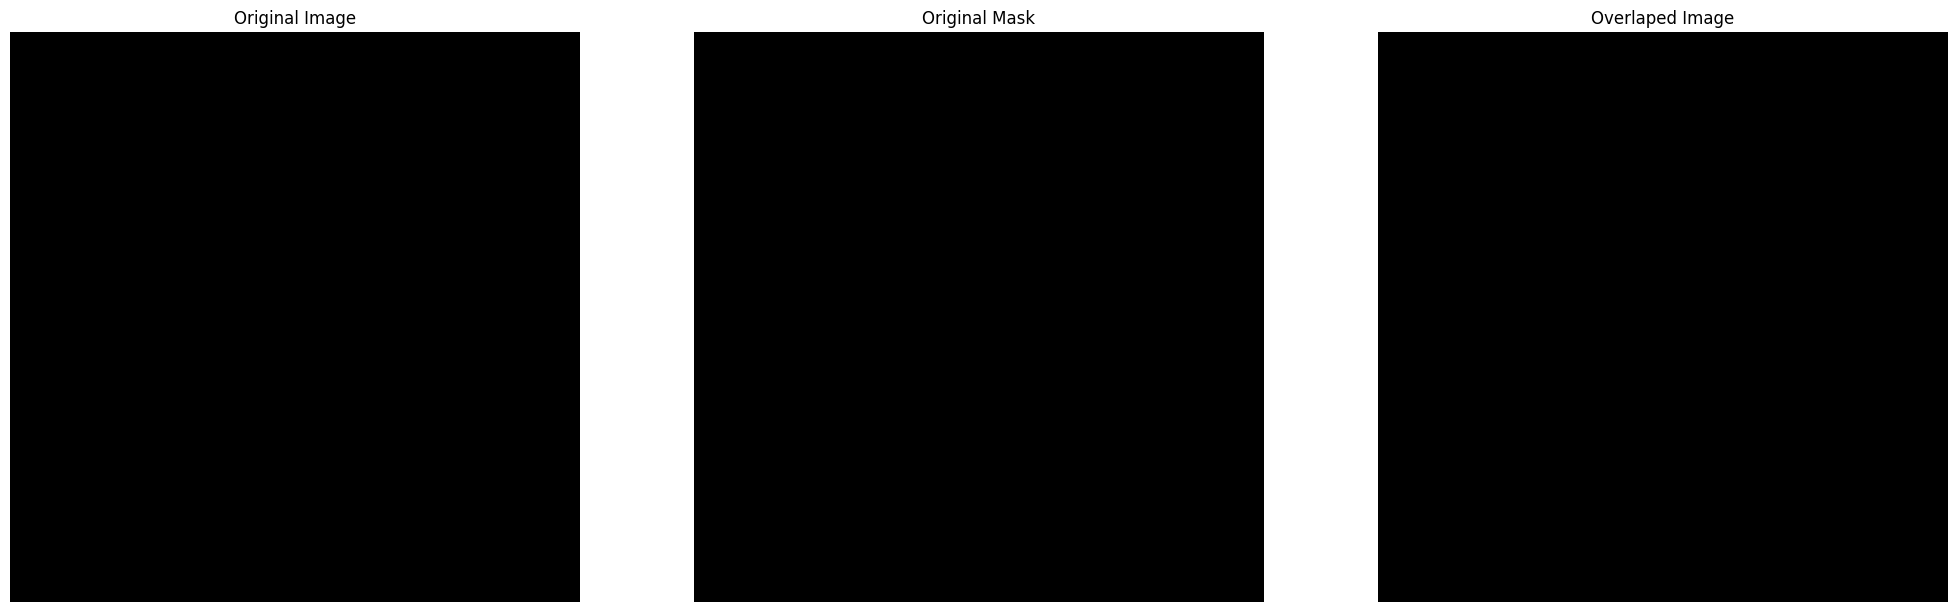

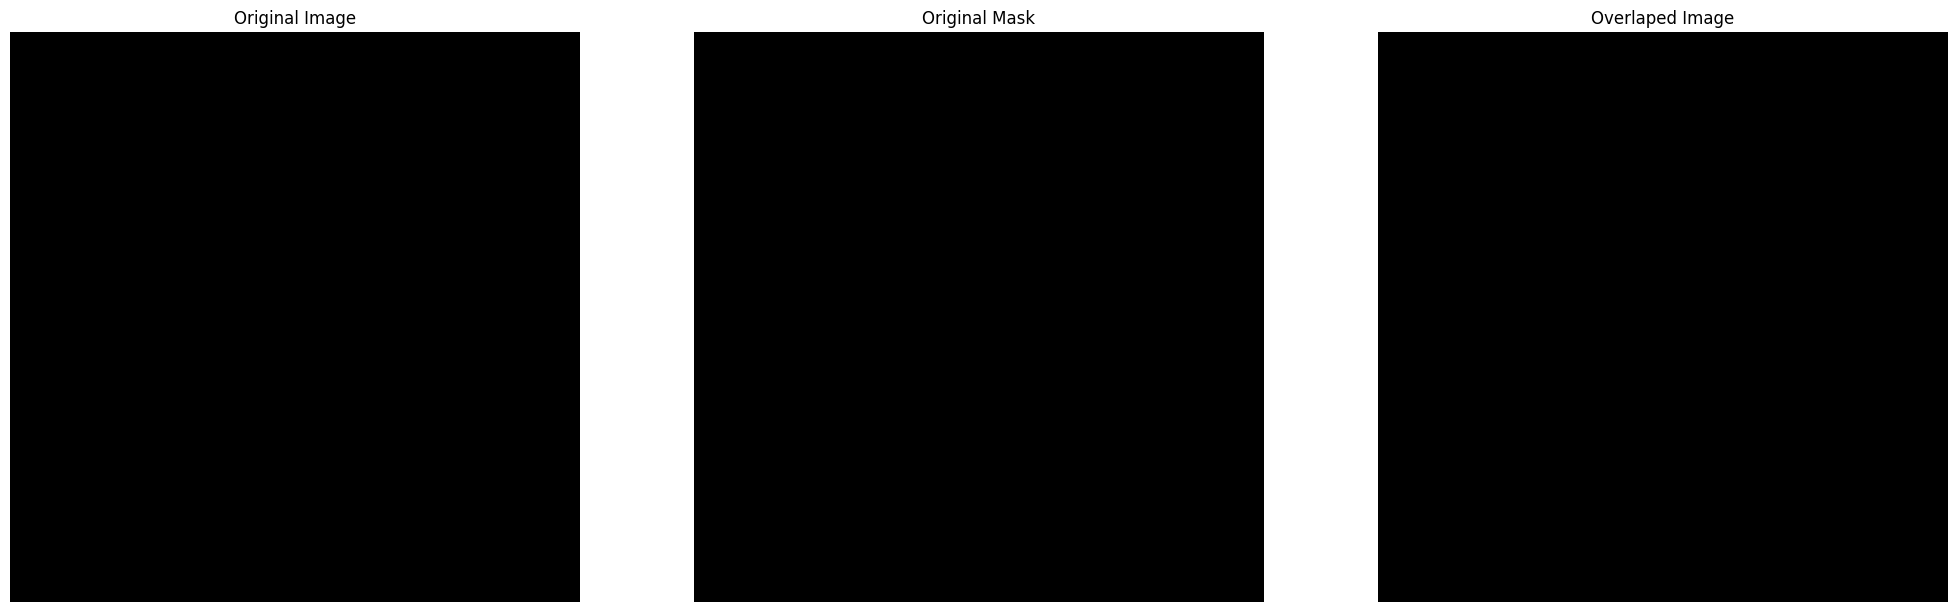

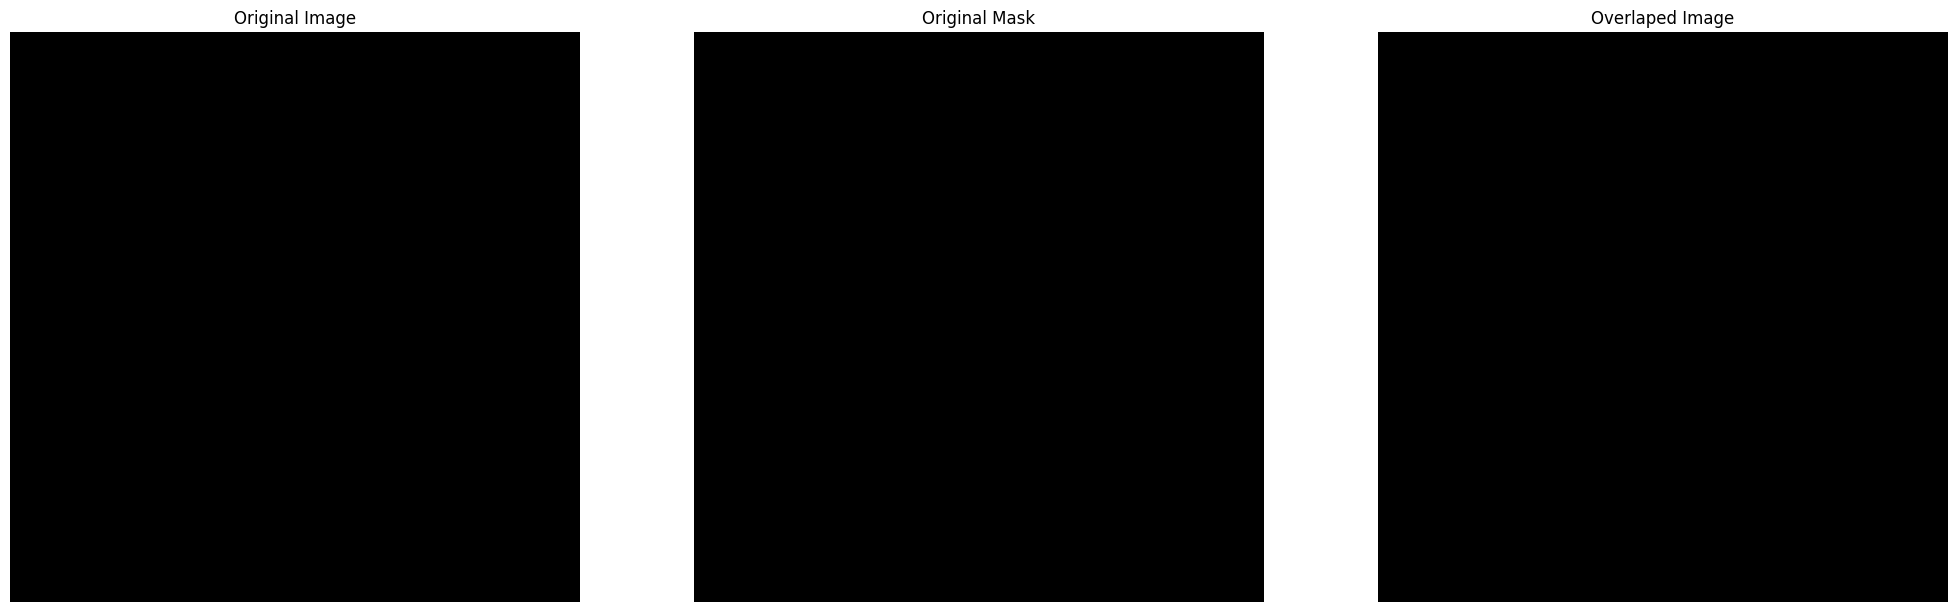

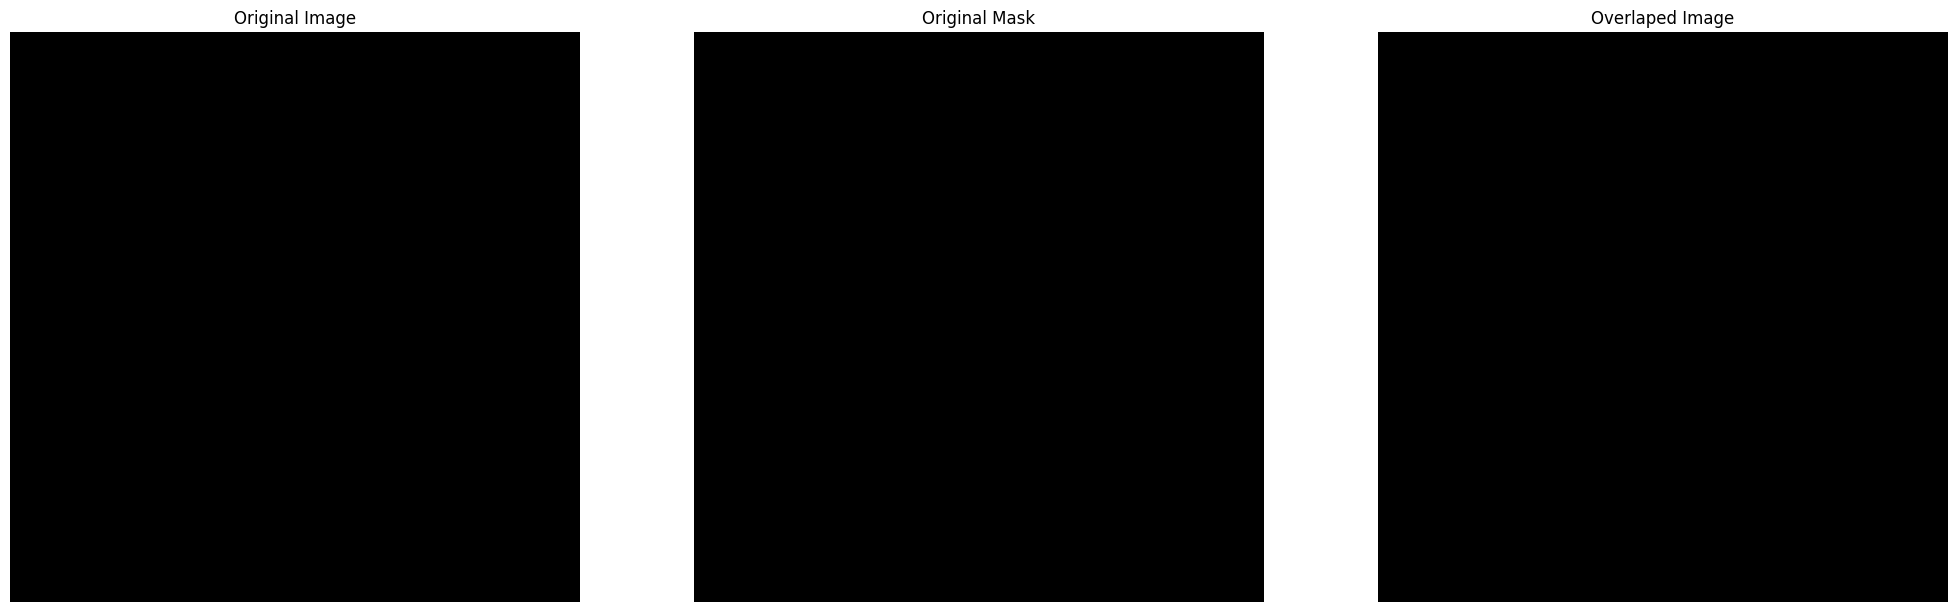

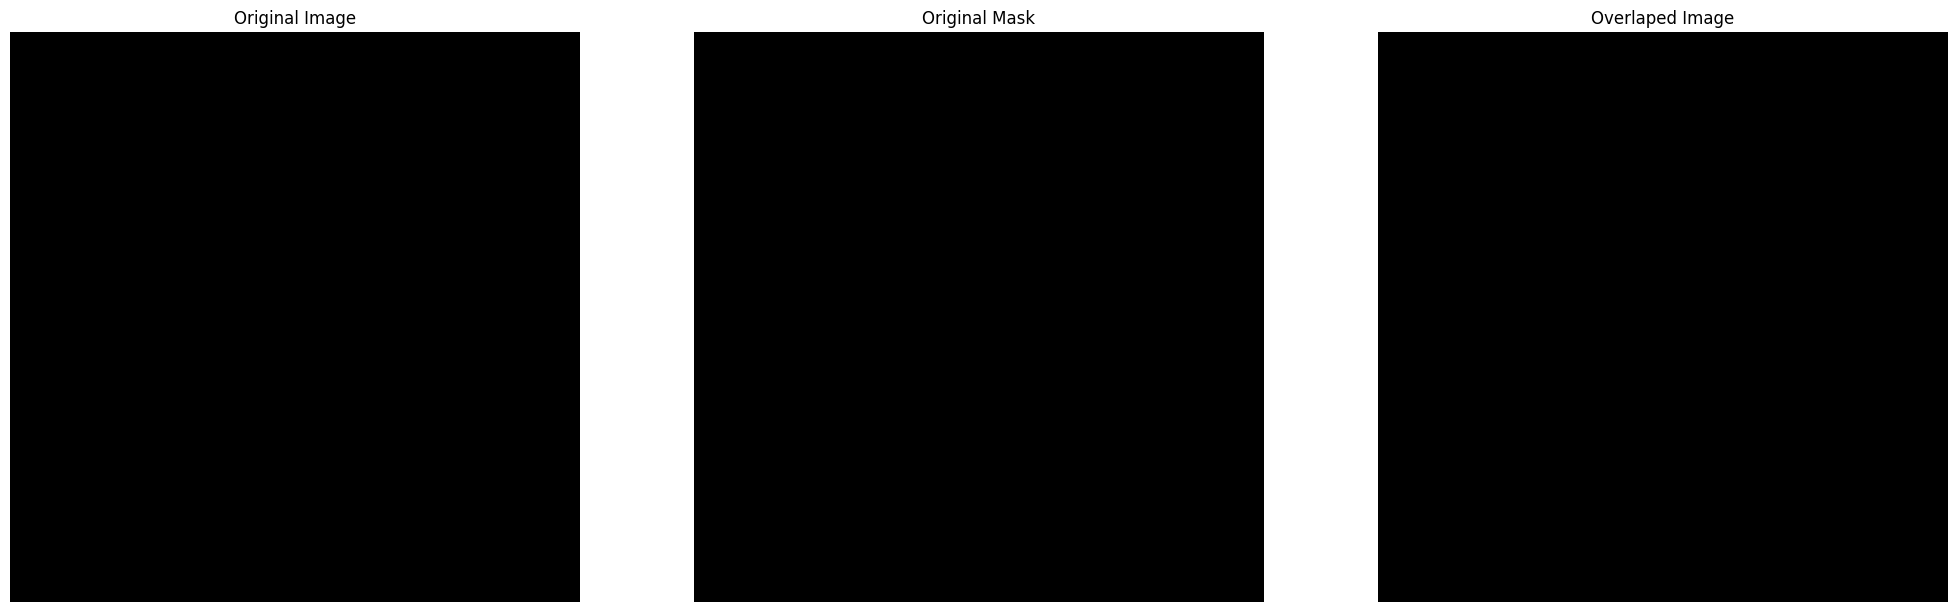

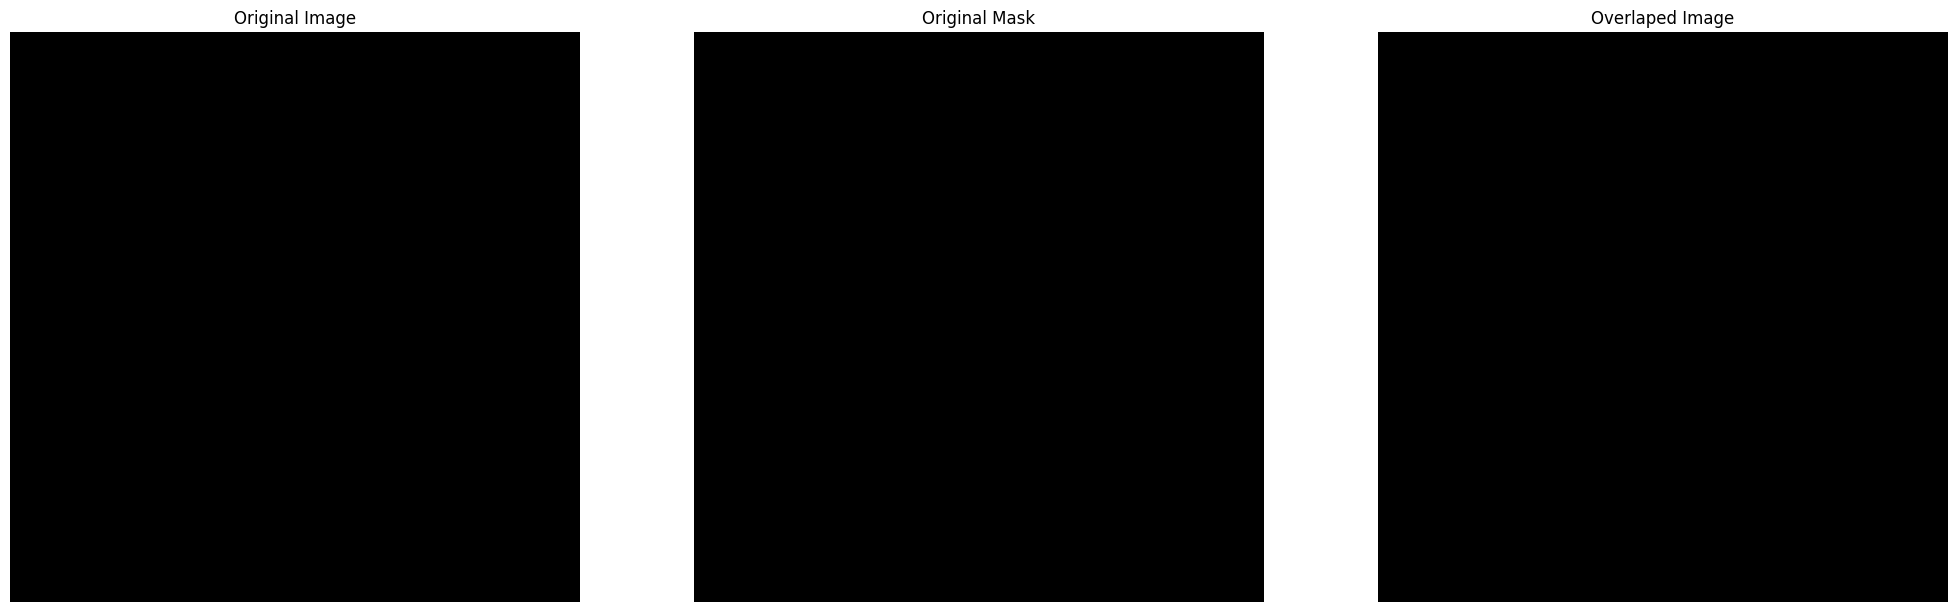

In [18]:
show_images(data=train_ds)

This is going to be a tough task.

# **DeepLabV3+**

In [19]:
class ConvBlock(Layer):
    
    def __init__(self, filters=256, kernel_size=3, use_bias=False, dilation_rate=1, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.use_bias = use_bias
        self.dilation_rate = dilation_rate
        
        self.net = Sequential([
            Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', dilation_rate=dilation_rate, use_bias=use_bias, kernel_initializer='he_normal'),
            BatchNormalization(),
            ReLU()
        ])
    
    def call(self, X): return self.net(X)        
        
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "kernel_size":self.kernel_size,
            "use_bias":self.use_bias,
            "dilation_rate":self.dilation_rate
        }

In [20]:
def AtrousSpatialPyramidPooling(X):
    
    # Shapes 
    _, height, width, _ = X.shape
    
    # Image Pooling 
    image_pool = AveragePooling2D(pool_size=(height, width), name="ASPP-AvgPool2D")(X)
    image_pool = ConvBlock(kernel_size=1, name="ASPP-ConvBlock-1")(image_pool)
    image_pool = UpSampling2D(size=(height//image_pool.shape[1], width//image_pool.shape[2]), name="ASPP-UpSampling")(image_pool)
    
    # Conv Blocks
    conv_1 = ConvBlock(kernel_size=1, dilation_rate=1, name="ASPP-Conv-1")(X)
    conv_6 = ConvBlock(kernel_size=3, dilation_rate=6, name="ASPP-Conv-6")(X)
    conv_12 = ConvBlock(kernel_size=3, dilation_rate=12, name="ASPP-Conv-12")(X)
    conv_18 = ConvBlock(kernel_size=3, dilation_rate=18, name="ASPP-Conv-18")(X)
    
    # Concat All
    concat = Concatenate(axis=-1, name="ASPP-Concat")([image_pool, conv_1, conv_6, conv_12, conv_18])
    net = ConvBlock(kernel_size=1, name="ASPP-Net")(concat)
    
    return net

In [21]:
# PARAM
LR = 1e-3
IMAGE_SIZE = 256

# Input
InputL = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")

# Base Mode
resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=InputL)

# ASPP Phase
DCNN = resnet50.get_layer('conv4_block6_2_relu').output
ASPP = AtrousSpatialPyramidPooling(DCNN)
ASPP = UpSampling2D(size=(IMAGE_SIZE//4//ASPP.shape[1], IMAGE_SIZE//4//ASPP.shape[2]), name="AtrousSpatial")(ASPP)

# LLF Phase
LLF = resnet50.get_layer('conv2_block3_2_relu').output
LLF = ConvBlock(filters=48, kernel_size=1, name="LLF-ConvBlock")(LLF)

# Combined
combined = Concatenate(axis=-1, name="Combine-LLF-ASPP")([ASPP, LLF])
features = ConvBlock(name="Top-ConvBlock-1")(combined)
features = ConvBlock(name="Top-ConvBlock-2")(features)
upsample = UpSampling2D(size=(IMAGE_SIZE//features.shape[1], IMAGE_SIZE//features.shape[1]), interpolation='bilinear', name="Top-UpSample")(features)

# Output Mask
PredMask = Conv2D(3, kernel_size=3, strides=1, padding='same', activation='sigmoid', use_bias=False, name="OutputMask")(upsample)

# DeelLabV3+ Model
model = Model(InputL, PredMask, name="DeepLabV3-Plus")
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "DeepLabV3-Plus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InputLayer          │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ InputLayer[0][0]  │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 11,858,752 (45.24 MB)

 Trainable params: 11,826,016 (45.11 MB)

 Non-trainable params: 32,736 (127.88 KB)

# **DeepLabV3+ Visualization**

In [22]:
plot_model(model, "DeepLabV3+.png", show_shapes=True, dpi=96)

# **DeepLabV3+ - Training**

In [23]:
# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

# Callback
class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1)%5==0:
            show_images(valid_ds, model=self.model, explain=True, n_images=2, SIZE=(25,10))

# Callbacks
callbacks = [ModelCheckpoint("DeepLabV3-Plus.keras"), ShowProgress()]

# Training
model.fit(train_ds, validation_data=valid_ds, epochs=50, callbacks=callbacks)


Epoch 1/50


I0000 00:00:1726173869.925537     133 service.cc:145] XLA service 0x7eb01c0035e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726173869.925589     133 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/25 ━━━━━━━━━━━━━━━━━━━━ 22:32 56s/step - loss: nan

I0000 00:00:1726173898.708910     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 337ms/step - loss: nan - val_loss: nan
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - loss: nan - val_loss: nan
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - loss: nan - val_loss: nan
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - loss: nan - val_loss: nan
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step/step - loss: na


ValueError: When providing `inputs` as a list/tuple, all values in the list/tuple must be KerasTensors. Received: inputs=[[<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=None, name=InputLayer>]] including invalid value [<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=None, name=InputLayer>] of type <class 'list'>

# **Model Predictions**

In [ ]:
show_images(train_ds, model=model, explain=True, n_images=10, SIZE=(20,8))

In [ ]:
show_images(valid_ds, model=model, explain=True, n_images=10, SIZE=(20,8))